<a href="https://colab.research.google.com/github/b-basic/IISc-Assignments/blob/main/Sem%202/E9%20246%20AIP/Assignment%202/q3_fcn_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**---INSTRUCTIONS---**

Please check the following link on how to import the kaggle dataset to google colab.

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

**--------------------------**

**NOTE** that Code given in the website is already written in **[1]** below. 

Just need to *download api credentials* (kaggle.json file) *from kaggle settings* as mentioned in step 2 of the link, and *then upload it on colab* as mentioned in step 3, and then run the code below. 

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download dansbecker/cityscapes-image-pairs
! unzip cityscapes-image-pairs

In [ ]:
import numpy as np
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plot
import seaborn as sns

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose

In [ ]:
def load_image(f_name, path):
    image = Image.open(os.path.join(path, f_name))
    image = np.array(image)
    
    # train set images contains actual image on left and segment map of image 
    # on right, side by side in single image file
    img = image[:,:256]
    seg_mask = image[:,256:]
    
    return img, seg_mask

In [ ]:
# params required for functions below
# height, width and classes all are properties of the dataset we are working with
width = 256
height = 256
classes = 13

In [ ]:
# binning pixel values from range (0, 255) to (0, 13) where 13 is the # of classes.
def bin_image(seg_mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(seg_mask, bins)
    return new_mask

In [ ]:
# convert the rgb segmentation maps to categorical maps (using new mask that we got by binning) 
# this will be used for training our model
def get_segmentation(new_mask, classes, width=width, height=height):
    segment_labels = np.zeros((height, width, classes))
    n_m = new_mask[:, : , 0]

    # one hot encoding of each pixel to its class number
    for c in range(classes):
        segment_labels[:, :, c] = (n_m == c ).astype(int)
    return segment_labels

In [ ]:
# categorized segment maps back to colored segmentation maps for visualization
def color_segmented(seg, num_classes):
    seg_img = np.zeros((seg.shape[0],seg.shape[1],3)).astype('float')
    colors = sns.color_palette("hls", num_classes)
    
    for c in range(num_classes):
        seg_c = (seg == c)
        seg_img[:,:,0] += (seg_c*( colors[c][0] ))
        seg_img[:,:,1] += (seg_c*( colors[c][1] ))
        seg_img[:,:,2] += (seg_c*( colors[c][2] ))

    return seg_img

In [ ]:
#  returns data in form of batches
# notice 'yield' keyword instead of 'return', that too inside of the for loop
def data_gen(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = load_image(file, path)
                mask_binned = bin_image(mask)
                labels = get_segmentation(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

In [ ]:
# # make sure you have followed the instructions on top of this page before running this

train_dir="/content/cityscapes_data/cityscapes_data/train"
valid_dir="/content/cityscapes_data/cityscapes_data/val"

num_of_training_samples = len(os.listdir(train_dir)) 
num_of_testing_samples = len(os.listdir(valid_dir))

In [ ]:
batch_size = 10

train_gen = data_gen(train_dir, batch_size=batch_size)
val_gen = data_gen(valid_dir, batch_size=batch_size)
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

In [ ]:
# # just to check output of above color_segmented() on a single image

# image = imgs[0]
# mask = color_segmented(np.argmax(segs[0], axis=-1),classes) # argmax basically reverses the one hot encoding
# masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

# fig, axs = plot.subplots(1, 3, figsize=(20,20))
# axs[0].imshow(image)
# axs[0].set_title('Original Image')
# axs[1].imshow(mask)
# axs[1].set_title('Segmentation Mask')
# axs[2].imshow(masked_image)
# axs[2].set_title('Masked Image')
# plot.show()

In [ ]:
# creating model by adding layers to pre-trained vgg network
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))
pool5 = vgg.get_layer('block5_pool').output 

# adding layers
conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
deconv_8 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
output_layer = Activation('softmax')(deconv_8)

model = Model(inputs=vgg.input, outputs=output_layer)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

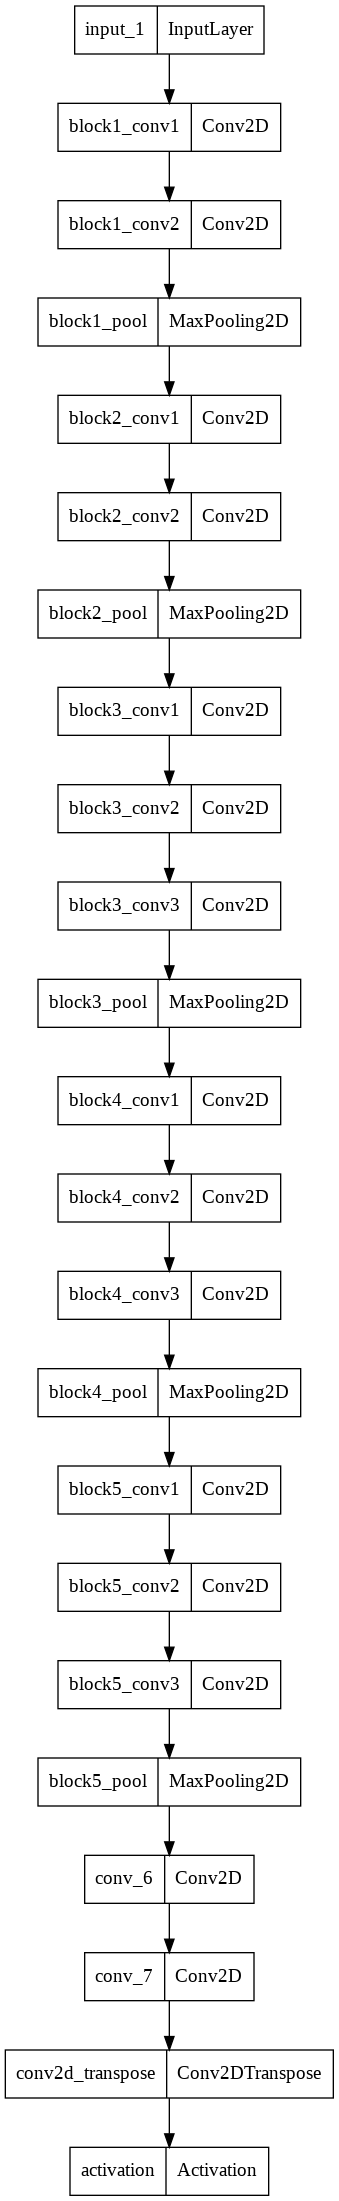

In [ ]:
plot_model(model)

In [ ]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpoint = ModelCheckpoint("best-model-vgg.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# # in case of colab session timeout / ram exceeded, to resume from a checkpoint. remember to change 
# # "model.fit_generator(..)" below to "new_model.fit_generator(..)"
# new_model = load_model("best-model-vgg.hdf5")

history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/10
  1/297 [..............................] - ETA: 3:09:21 - loss: 1.6936 - accuracy: 0.4446

Process Keras_worker_ForkPoolWorker-4:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
model.load_weights("best-model-vgg.hdf5")
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] #accuracy

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

In [ ]:
imgs, segs = next(val_gen)
pred = model.predict(imgs)

_p = color_segmented(np.argmax(pred[0], axis=-1))
_s = color_segmented(np.argmax(segs[0], axis=-1))

predimg = cv2.addWeighted(imgs[0]/255, 0.5, _p, 0.5, 0)
trueimg = cv2.addWeighted(imgs[0]/255, 0.5, _s, 0.5, 0)

plot.figure(figsize=(12,6))
plot.subplot(121)
plot.title("Prediction")
plot.imshow(predimg)
plot.axis("off")
plot.subplot(122)
plot.title("Original")
plot.imshow(trueimg)
plot.axis("off")
plot.tight_layout()
plot.savefig("pred_"+str(0)+".png", dpi=150)
plot.show()